# Low-Rank Matrix Completion

# Milad Jalali, Alireza Naderi

# Introduction

# Basics

In [3]:
import argparse
import os
import pickle
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from numpy.linalg import solve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

np.random.seed(1337)

def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys)

# Projection onto the nuclear norm ball

In [35]:
def simplex_projection(a):
    #check if the point is already in the simplex
    if np.sum(a) <=1 and np.alltrue(a >= 0):
        return a
    # sort the array in decreasing order then compute cumulative sum of array elements
    s = np.sort(a)[::-1]
    cumsum_u = np.cumsum(s)
    # rho is the number of nonzero elements of the solution
    rho = np.nonzero(s * np.arange(1, len(s)+1) > (cumsum_u - 1))[0][-1]
    # theta is the lagrangian multiplier
    theta = (cumsum_u[rho] - 1) / (rho + 1.0)
    # thresholding
    return np.maximum(a-theta, 0)

In [36]:
def nuclear_projection(A):
    U, sigma, V = np.linalg.svd(A, full_matrices=False)
    projected_sigma = simplex_projection(sigma)
    return U.dot(np.diag(projected_sigma).dot(V))

# Objective Function & Gradient

In [42]:
def my_function(M, O, X):
    return 0.5 * np.linalg.norm(M-np.multiply(X, O), 'fro')**2

In [16]:
def my_function_gradient(M, O, X):
    return np.multiply(X, O) - M

In [74]:
n = 1000
k = 10
# we will produce a (n,n) square matrix of rank k named A
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
S = np.diag(np.random.uniform(0, 1, k))
S /= np.sum(S)
A = U.dot(S.dot(U.T))
# O represents the observed enteries 
O = np.random.randint(0,2, (n, n))
M = np.multiply(A, O)
M

array([[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  6.51186594e-04,  0.00000000e+00],
       [ 3.24096434e-05,  1.15004929e-03,  3.47836366e-04, ...,
         0.00000000e+00, -0.00000000e+00,  1.15675337e-04],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -0.00000000e+00, -3.12222822e-04],
       ...,
       [ 4.49255456e-05,  0.00000000e+00,  1.99735806e-04, ...,
         6.81184484e-04, -0.00000000e+00, -0.00000000e+00],
       [ 6.51186594e-04, -1.69057641e-04, -0.00000000e+00, ...,
        -0.00000000e+00,  6.71810769e-04,  3.23085247e-04],
       [ 4.36655458e-04,  1.15675337e-04, -0.00000000e+00, ...,
        -0.00000000e+00,  0.00000000e+00,  8.03406194e-04]])

In [75]:
X0 = np.random.normal(0,1, (n,n))
X0 = nuclear_projection(X0.dot(X0.T))
print(my_function(M, O, X0))
print(my_function_gradient(M, O, X0))

0.279724390920091
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -4.68899954e-04  0.00000000e+00]
 [-2.52944954e-05 -1.14739275e-03 -3.51071591e-04 ...  0.00000000e+00
   0.00000000e+00 -1.03730531e-04]
 [ 0.00000000e+00 -0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
   0.00000000e+00  2.97676035e-04]
 ...
 [ 2.33294475e-04  0.00000000e+00 -3.26241189e-04 ...  3.38068060e-03
   0.00000000e+00  0.00000000e+00]
 [-4.68899954e-04  2.37116947e-04  0.00000000e+00 ...  0.00000000e+00
   1.07183563e-03 -1.70651001e-05]
 [-4.04663086e-04 -1.03730531e-04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -7.49697867e-04]]


# Power Method

In [26]:
def power_method(A, num_steps=10):
    n, m = A.shape
    x = np.random.normal(0, 1, n).reshape(-1,1)
    x /= np.linalg.norm(x)
    y = A.T.dot(x)
    y /= np.linalg.norm(y)
    for _ in range(num_steps):
        x = A.dot(y)
        x /= np.linalg.norm(x)
        y = A.T.dot(x)
        y /= np.linalg.norm(y)
    return x, y

# Oracle Computation

In [47]:
def my_oracle(M, O, X):
    G = my_function_gradient(M, O, X)
    x, y = power_method(-G)
    return x.T.dot(y)

In [49]:
my_oracle(M, O, X0)

array([[-0.78396866]])

# Frank Wolfe

In [50]:
def frank_wolfe(init, steps, oracle):
    xs = [init]
    
    for step in steps:
        xs.append(xs[-1] + step*(oracle(xs[-1])-xs[-1]))        
    return xs

In [76]:
oracle = lambda X: my_oracle(M, O, X)
steps = [2./(k+2.) for k in range(1, 50)]
Xs = frank_wolfe(X0, steps, oracle)

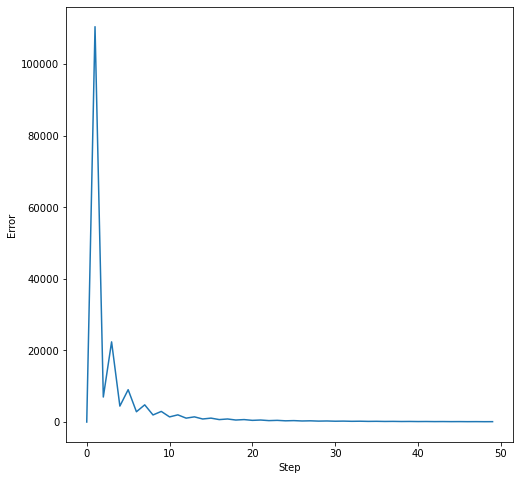

In [77]:
function = lambda X: my_function(M, O, X)
objective = [function(X) for X in Xs]
domain = [np.linalg.norm(X-M, 'fro')**2 for X in Xs]

plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Error')
# plt.yscale('log')
plt.plot(range(len(objective)), objective)

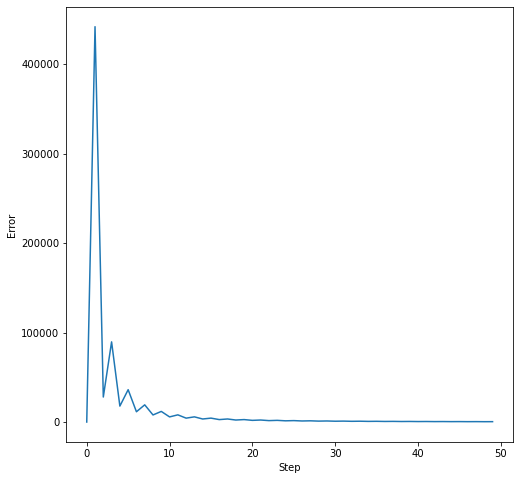

In [78]:
plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Error')
plt.plot(range(len(domain)), domain)